
# MNIST Classification: Logistic Regression, Linear SVM, Decision Tree, Random Forest, XGBoost

This notebook trains and evaluates multiple classifiers on the **MNIST** dataset (70,000 images, 28×28) and compares their performance.


In [1]:

# Imports & configuration
import time
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception as e:
    print("xgboost not available:", e)
    XGB_AVAILABLE = False

# Reproducibility & knobs
RANDOM_STATE = 42
TEST_SIZE = 0.2

MAX_TRAIN_SAMPLES = 20000   # set to None to use full MNIST
N_MISCLASSIFIED = 8         

# Enable cross-validation on a subset
USE_CROSS_VALIDATION = False
CV_FOLDS = 3
CV_MAX_SAMPLES = 10000


# Data Loading 

In [2]:
# Using the exact snippet requested for shape sanity-check:
X, y = fetch_openml('mnist_784', return_X_y=True)
print("Raw shapes:", X.shape, y.shape)

# Convert labels to integers (OpenML returns strings)
y = y.astype(np.int64).values if hasattr(y, "values") else y.astype(np.int64)

X = X.to_numpy() if hasattr(X, "to_numpy") else np.asarray(X)

#  subsample to speed up experimentation on modest hardware
if MAX_TRAIN_SAMPLES is not None and X.shape[0] > MAX_TRAIN_SAMPLES:
    rng = np.random.default_rng(RANDOM_STATE)
    idx = rng.choice(X.shape[0], size=MAX_TRAIN_SAMPLES, replace=False)
    X = X[idx]
    y = y[idx]
    print(f"Subsampled to {X.shape[0]} examples for faster training.")

# Normalize pixel values to [0, 1]
X = X / 255.0

# Train / test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, " Test:", X_test.shape)


Raw shapes: (70000, 784) (70000,)
Subsampled to 20000 examples for faster training.
Train: (16000, 784)  Test: (4000, 784)


#  Define models 

In [3]:
models = {}

# Logistic Regression (multinomial)
models["LogisticRegression"] = LogisticRegression(
    multi_class="multinomial", solver="lbfgs", max_iter=200, n_jobs=None, random_state=RANDOM_STATE
)


In [4]:
# Linear SVM (LinearSVC scales better than RBF SVC on MNIST)
models["LinearSVM"] = LinearSVC(
    C=1.0, random_state=RANDOM_STATE
)


In [5]:
# Decision Tree
models["DecisionTree"] = DecisionTreeClassifier(
    max_depth=20, random_state=RANDOM_STATE
)


In [6]:
# Random Forest
models["RandomForest"] = RandomForestClassifier(
    n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1
)

In [7]:
# XGBoost 
if XGB_AVAILABLE:
    models["XGBoost"] = XGBClassifier(
        objective="multi:softprob",
        num_class=10,
        n_estimators=300,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        random_state=RANDOM_STATE,
        verbosity=0
    )
else:
    print("Skipping XGBoost (package not available).")


# Train, predict, evaluate 

In [8]:
reports = {}
conf_matrices = {}
accuracies = {}
times = {}
predictions = {}

for name, clf in models.items():
    print(f"\n=== Training {name} ===")
    start = time.perf_counter()
    clf.fit(X_train, y_train)
    train_time = time.perf_counter() - start
    times[name] = train_time
    print(f"{name} trained in {train_time:.2f} s")

    y_pred = clf.predict(X_test)
    predictions[name] = y_pred

    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"{name} accuracy: {acc:.4f}")

    # classification report (as dict + text)
    rep_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    reports[name] = rep_dict

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(10))
    conf_matrices[name] = cm

print("\nDone training all models.")



=== Training LogisticRegression ===


C:\Users\DuaaHilal\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression trained in 12.10 s
LogisticRegression accuracy: 0.9048

=== Training LinearSVM ===
LinearSVM trained in 22.91 s
LinearSVM accuracy: 0.8995

=== Training DecisionTree ===
DecisionTree trained in 15.36 s
DecisionTree accuracy: 0.8300

=== Training RandomForest ===
RandomForest trained in 13.00 s
RandomForest accuracy: 0.9605

=== Training XGBoost ===
XGBoost trained in 407.80 s
XGBoost accuracy: 0.9665

Done training all models.


# Metrics summary table 

In [10]:
rows = []
for name, rep in reports.items():
    macro = rep.get("macro avg", {})
    weighted = rep.get("weighted avg", {})
    rows.append({
        "model": name,
        "accuracy": accuracies[name],
        "precision_macro": macro.get("precision", np.nan),
        "recall_macro": macro.get("recall", np.nan),
        "f1_macro": macro.get("f1-score", np.nan),
        "precision_weighted": weighted.get("precision", np.nan),
        "recall_weighted": weighted.get("recall", np.nan),
        "f1_weighted": weighted.get("f1-score", np.nan),
        "train_time_sec": times[name]
    })

metrics_df = pd.DataFrame(rows).sort_values(by="accuracy", ascending=False).reset_index(drop=True)
metrics_df


,model,accuracy,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,train_time_sec
0,XGBoost,0.96650,0.966375,0.966045,0.966110,0.966668,0.96650,0.966486,407.796471
1,RandomForest,0.96050,0.960459,0.960188,0.960178,0.960754,0.96050,0.960483,12.996461
2,LogisticRegression,0.90475,0.904010,0.903068,0.903350,0.904760,0.90475,0.904567,12.097333
3,LinearSVM,0.89950,0.898340,0.897718,0.897914,0.899227,0.89950,0.899247,22.910978
4,DecisionTree,0.83000,0.827498,0.827156,0.827094,0.830051,0.83000,0.829797,15.355440


# Print full classification reports 

In [12]:
for name in reports:
    print(f"\n{name}:\n" + "-"*60)
    print(classification_report(y_test, predictions[name], zero_division=0))



LogisticRegression:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       404
           1       0.94      0.97      0.95       464
           2       0.91      0.89      0.90       395
           3       0.85      0.86      0.86       411
           4       0.90      0.88      0.89       392
           5       0.89      0.86      0.87       349
           6       0.93      0.97      0.95       389
           7       0.90      0.92      0.91       416
           8       0.88      0.85      0.86       387
           9       0.87      0.89      0.88       393

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000


LinearSVM:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.

# Bar chart: Accuracy 

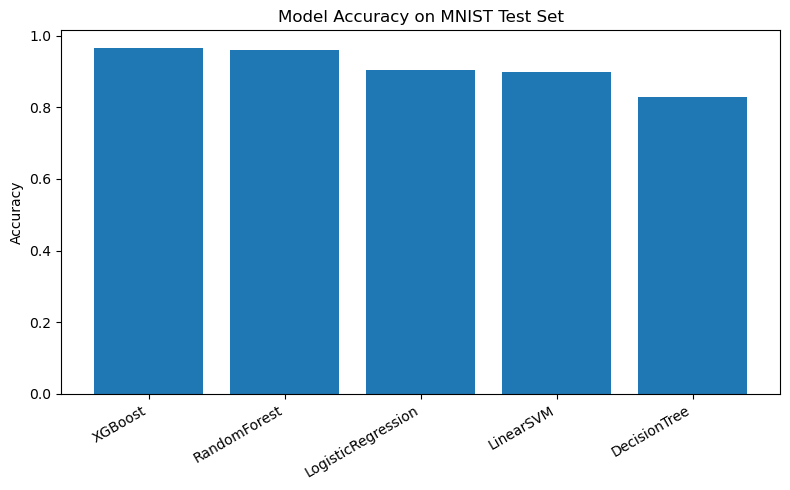

In [13]:
plt.figure(figsize=(8, 5))
plt.bar(metrics_df["model"], metrics_df["accuracy"])
plt.title("Model Accuracy on MNIST Test Set")
plt.ylabel("Accuracy")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

#  Confusion matrices 

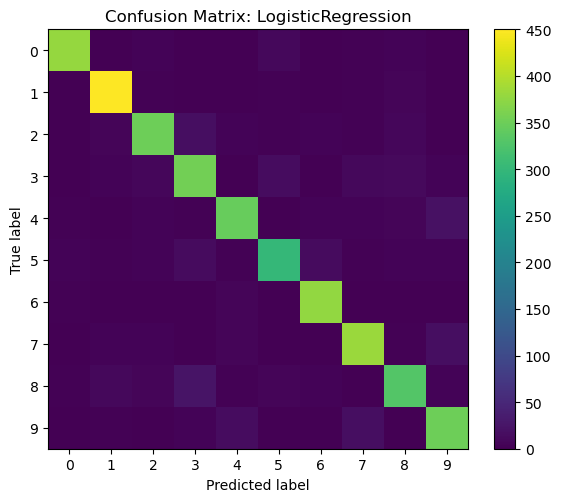

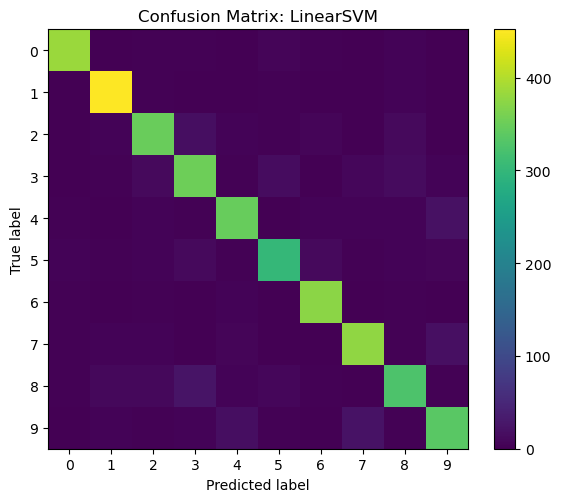

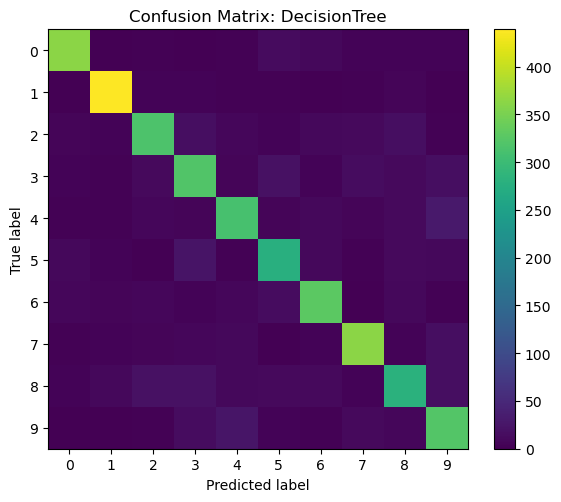

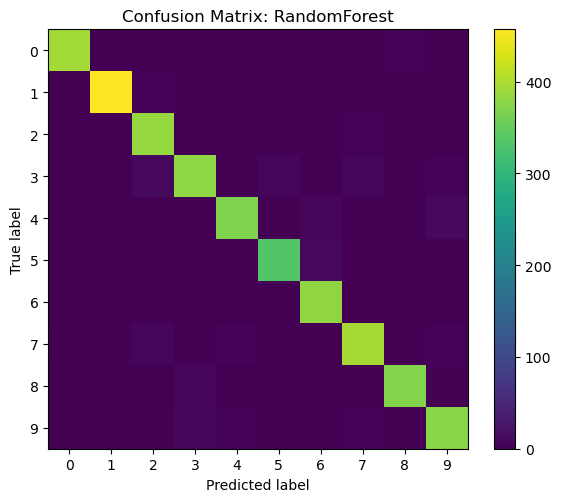

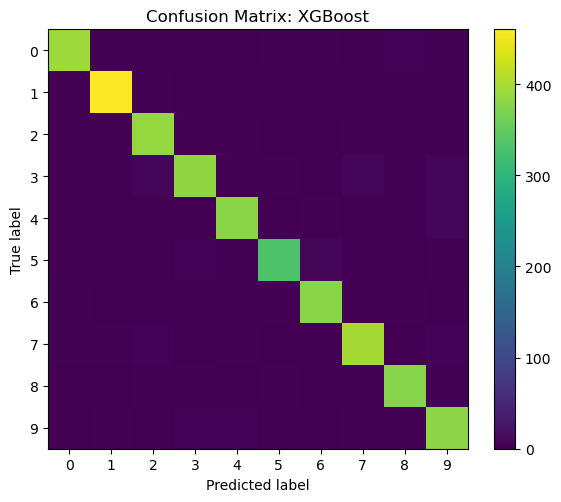

In [14]:
labels = np.arange(10)

for name, cm in conf_matrices.items():
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.show()


# Misclassified samples per model 


Misclassified examples for LogisticRegression:


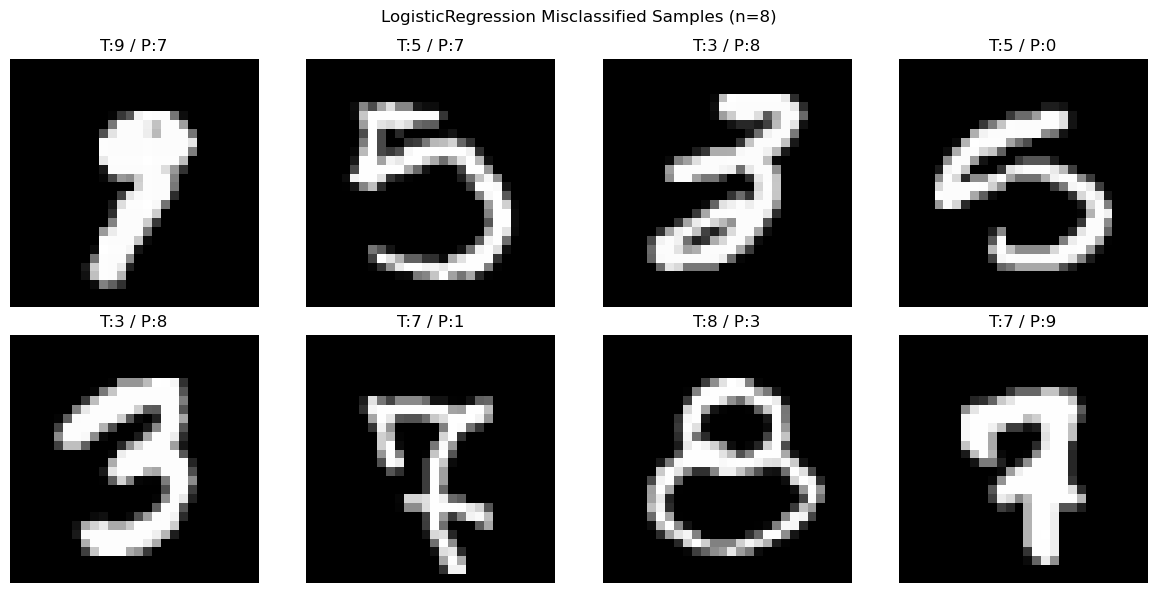


Misclassified examples for LinearSVM:


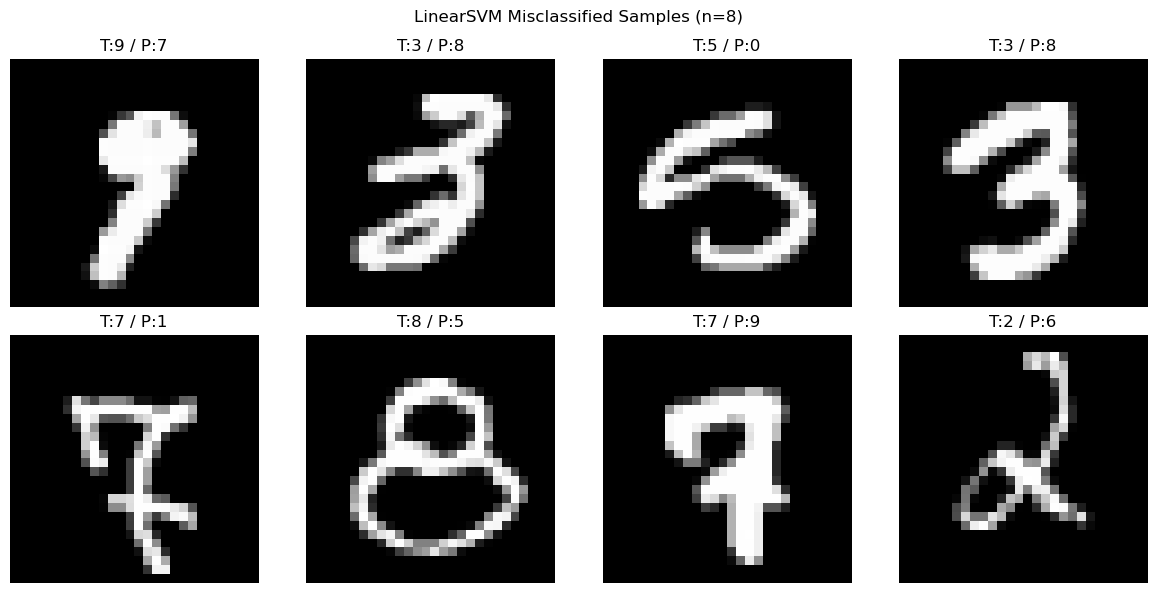


Misclassified examples for DecisionTree:


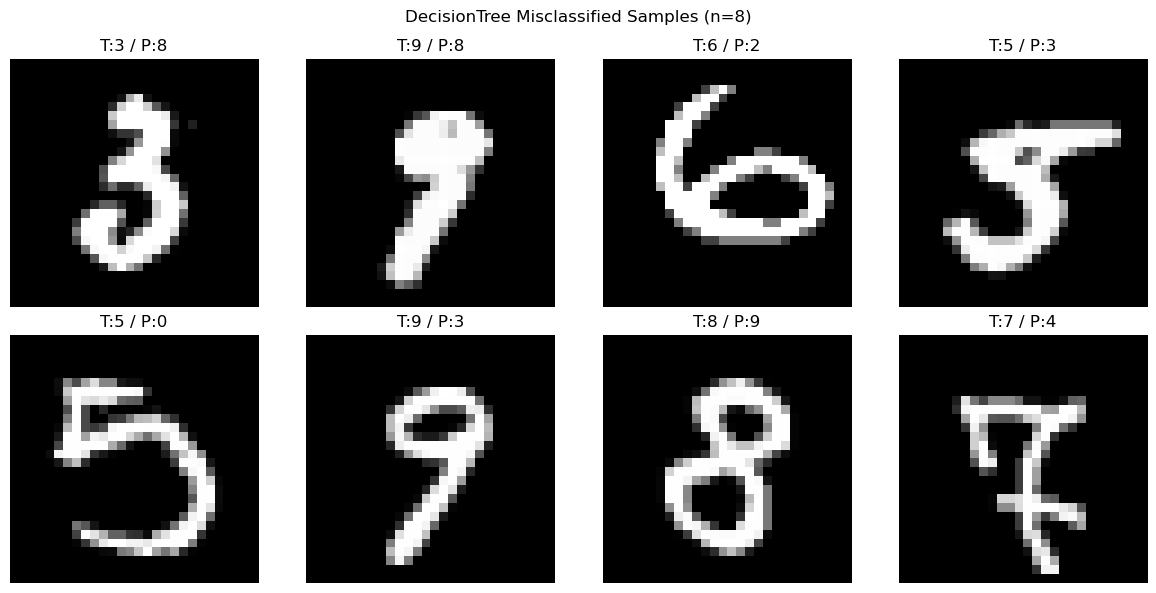


Misclassified examples for RandomForest:


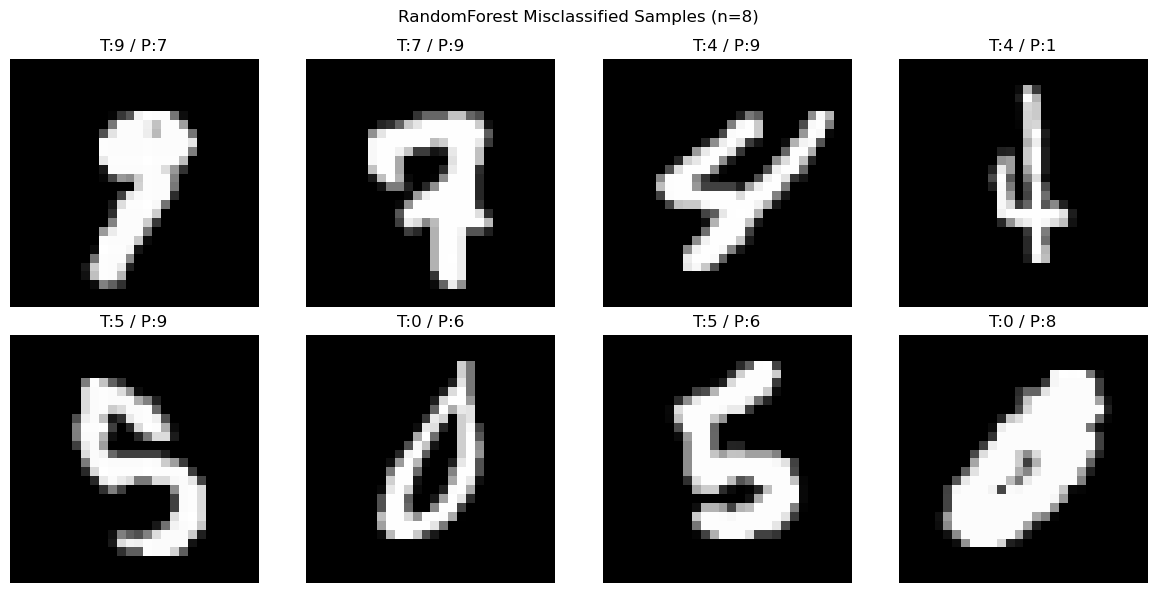


Misclassified examples for XGBoost:


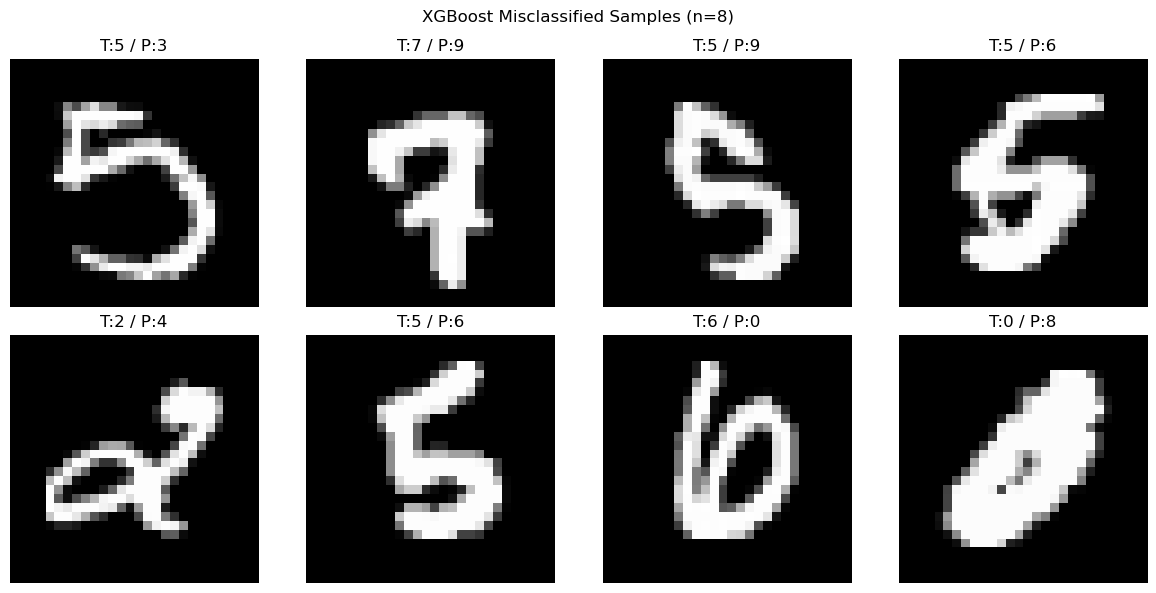

In [15]:
# Reshape helper to 28x28 for visualization
def show_misclassified_images(X_raw_flat, y_true, y_pred, n=8, title_prefix=""):
    mis_idx = np.where(y_true != y_pred)[0]
    if len(mis_idx) == 0:
        print("No misclassifications found.")
        return
    n = min(n, len(mis_idx))
    chosen = mis_idx[:n]

    cols = 4
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols*3, rows*3))
    for i, idx in enumerate(chosen, 1):
        img = X_raw_flat[idx].reshape(28, 28)  # MNIST shape
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap="gray")
        plt.title(f"T:{y_true[idx]} / P:{y_pred[idx]}")
        plt.axis("off")
    plt.suptitle(f"{title_prefix} Misclassified Samples (n={n})")
    plt.tight_layout()
    plt.show()

for name, y_pred in predictions.items():
    print(f"\nMisclassified examples for {name}:")
    show_misclassified_images(X_test, y_test, y_pred, n=N_MISCLASSIFIED, title_prefix=name)


# Training time comparison 

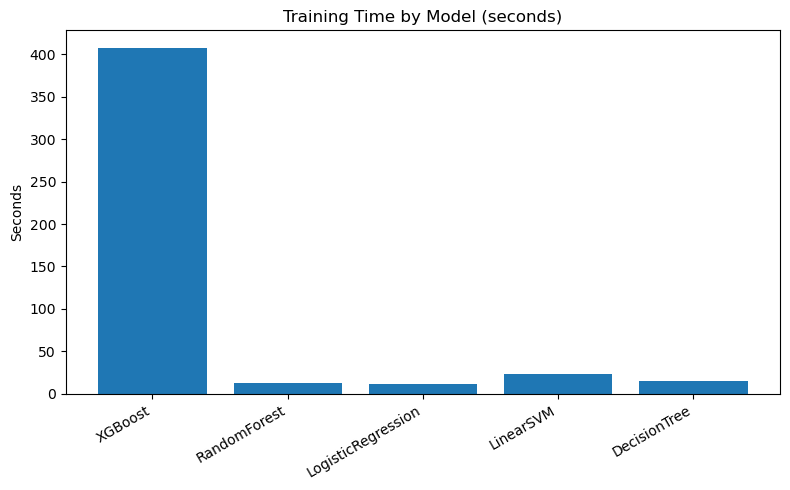

In [16]:
plt.figure(figsize=(8,5))
plt.bar(metrics_df["model"], metrics_df["train_time_sec"])
plt.title("Training Time by Model (seconds)")
plt.ylabel("Seconds")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()